In [1]:
import merger
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%time
dates, positions = merger.get_data_from_db(95, 2)

CPU times: user 1.7 s, sys: 73.6 ms, total: 1.77 s
Wall time: 29.6 s


In [3]:
trajects = merger.extract_trajects(dates, positions)

13420 trajets
8% font moins de 10 arrêts
14% font moins de 15 arrêts


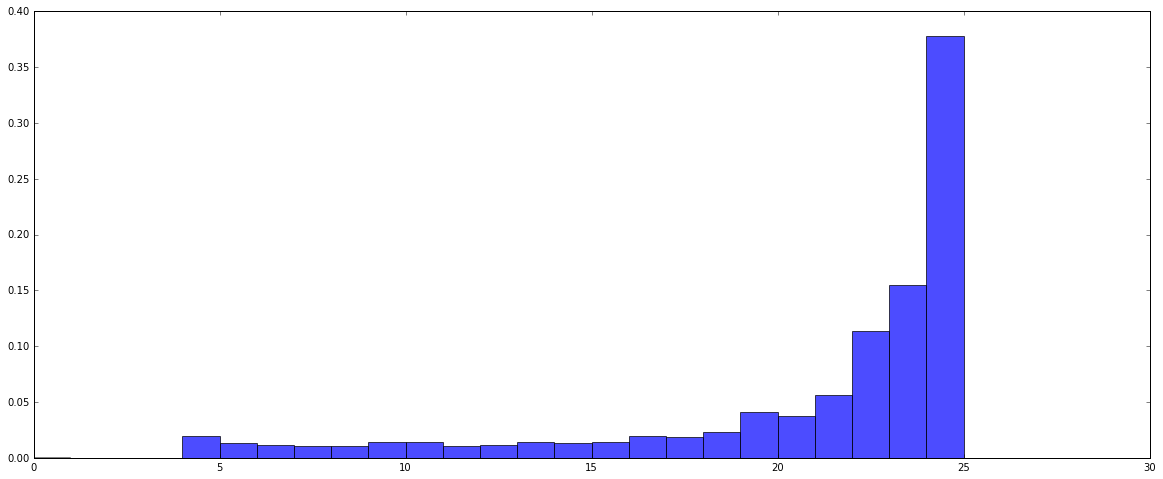

In [4]:
lengths = [len(traject) for traject in trajects]

print("%i trajets" % len(trajects))
percentage = len([x for x in lengths if x < 10])*100/len(lengths)
print("%i%% font moins de 10 arrêts" % percentage)

percentage = len([x for x in lengths if x < 15])*100/len(lengths)
print("%i%% font moins de 15 arrêts" % percentage)

plt.hist(lengths, bins=range(0,30), alpha=0.7, normed=True);

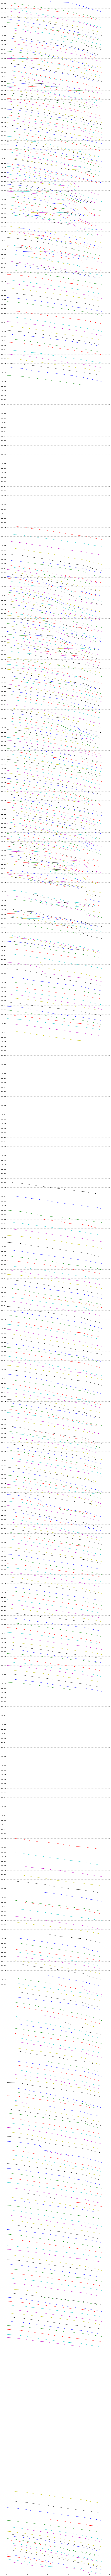

In [5]:
fig, ax = plt.subplots(figsize=(20,500))

ax.grid(True)
ax.invert_yaxis()

ax.yaxis.set_major_locator(MinuteLocator(interval=10))
ax.yaxis.set_major_formatter(DateFormatter('%m/%d %H:%M'))

for traject in trajects[600:1200]:
    traject = sorted(traject.items(), key=lambda x: x[1])
    plt.plot([x[0] for x in traject], [x[1] for x in traject], linewidth=1)


In [34]:
import sklearn
import numpy as np

In [135]:
t = trajects[102]
def traject_to_durations(t):
    durations = [None] * 23
    for i in range(23):
        try:
            durations[i] = (t[i + 1] - t[i]).total_seconds()
        except KeyError:
            durations[i] = np.NaN
    return durations

In [136]:
fv = np.array([traject_to_durations(t) for t in trajects])

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values="NaN", strategy='mean', axis=0)

fv = imp.fit_transform(fv)

In [137]:
X, Y = fv[:,:12], fv[:,12:]
# X, Y = fv[:2000,:12], fv[:2000,12:]

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [138]:
from sklearn.metrics import make_scorer

def distance(ground_truth, predictions):
    return abs(np.linalg.norm(ground_truth - predictions, axis=1).mean())

loss  = make_scorer(distance, greater_is_better=False)


In [156]:
%%time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.grid_search import GridSearchCV
nbrs = KNeighborsRegressor()
available_k = np.hstack((np.arange(1, 20), np.arange(20, 500, 10)))

grid = GridSearchCV(estimator=nbrs, scoring=loss, param_grid=dict(n_neighbors=available_k), n_jobs=3)
grid.fit(X_train, Y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_neighbors': array([  1,   2, ..., 480, 490])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(distance, greater_is_better=False), verbose=0)
-139.591574679
130
CPU times: user 1.26 s, sys: 142 ms, total: 1.4 s
Wall time: 57.3 s


In [157]:
%%time
knn = KNeighborsRegressor(n_neighbors=grid.best_estimator_.n_neighbors).fit(X_train, Y_train)

CPU times: user 8.06 ms, sys: 1 ms, total: 9.06 ms
Wall time: 8.24 ms


In [173]:
i = 1001
p = knn.predict([X_test[i]]) / 60
r = Y_test[i]/ 60
print(np.vstack((p.round(1),r.round(1))))
print((p.sum() - r.sum()), r.sum())
print((abs(p-r)*60).round())

[[ 1.2  2.1  1.9  1.3  1.9  1.2  2.1  2.7  2.   2.1  2.7]
 [ 0.7  3.   2.   1.3  3.3  0.7  2.3  2.3  1.7  1.7  2. ]]
0.0791329504626 20.9988329
[[ 35.  52.   8.   0.  89.  31.  15.  20.  19.  23.  40.]]


In [162]:
import tensorflow as tf